<a href="https://colab.research.google.com/github/aliciafmachado/amf-challenge/blob/main/Project_INF569.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Who are the high-frequency traders ?
### by Autorité des Marchés Financiers


Alicia Fortes Machado & Iago Martinelli Lopes

This notebook explore different techniques in order to classify the traders within three categories: HFT, non-HFT and MIX.

The dataset has 35 variables explaining statistics for each set of market player, stock and specific trading date.

## Connect to Google Drive

We connect to Google Drive if you chose this option.

If not, you can jump this section.

In [1]:
# Import and save into google drive
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/My Drive/MAP569/project'
%ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/MAP569/project
data/


## Import libraries

We import all necessary libraries:

In [2]:
%%capture
!pip install seaborn
!pip install --upgrade setuptools
!pip install --upgrade numpy
!pip install --upgrade scipy
!pip install -U scikit-learn
!pip install -U scikit-learn

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
sns.set(style='ticks')

## Analysis of the data

We first open the dataset:

In [4]:
# main path to our dataset
data_path = "data"

train_x_path = os.path.join(data_path, 'AMF_train_X_XCZw8r3.csv')
train_y_path = os.path.join(data_path, 'AMF_train_Y_omYQJZL.csv')

eval_path = os.path.join(data_path, 'AMF_test_X_uDs0jHH.csv')

train_x_df = pd.read_csv(train_x_path, index_col='Index')
train_y_df = pd.read_csv(train_y_path, index_col=None)

eval_df = pd.read_csv(eval_path, index_col='Index')

We will join our train_x_df and train_y_df in order to better visualize our problem.

In [6]:
# add label in train_x
train_xy = pd.merge(train_x_df, train_y_df, left_on="Trader", right_on="Trader")

Now let's look at the distribution of the labels in our Dataset.

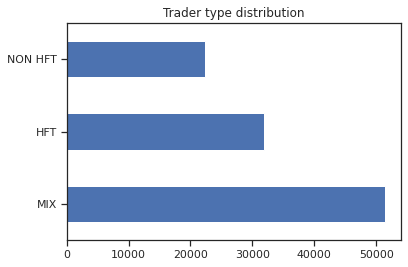

In [ ]:
train_xy['type'].value_counts().plot.barh()
plt.title("Trader type distribution")
plt.show()

To conclude this first step, our Dataset is a little unbalanced. There are much more trades performed by a MIX Trader than trades performed by NON FHT Traders. But it is not extremelly unbalanced to the point of compromising models. In any case, F1-Score looks like a better metric to evaluate the model comapred to accuracy.

### NaN Values

The first thing we notice in our Dataset is the presence of NaN values, and this occurs mainly because there are Traders who uses only one Trading Venue to trade. So, most of our NaN values do not correspond to a missing information, so we need to treat them in a different way than simply dropping the columns and rows, or replacing them with the average.

To begin, we will see which columns have missing values, how many rows and its importance for our problem.

In [ ]:
var = train_xy.isnull().sum()

for i in range(var.size):
  if var.iloc[i] != 0:
    print(var.index[i] + " " + str(var.iloc[i]))

OTR 1683
OMR 47612
min_dt_TV1 4235
mean_dt_TV1 4235
med_dt_TV1 4235
min_dt_TV1_TV2 25176
mean_dt_TV1_TV2 25176
med_dt_TV1_TV2 25176
min_dt_TV1_TV3 25255
mean_dt_TV1_TV3 25255
med_dt_TV1_TV3 25255
min_dt_TV1_TV4 25148
mean_dt_TV1_TV4 25148
med_dt_TV1_TV4 25148


As expected, the majority of NaN values correspond to the column values of TV from 2 to 4. It means that these Traders do not use these Trading Venues, and we must use this information in our problem.

Now, we will plot some graphs to observe how relevant these NaN values are.

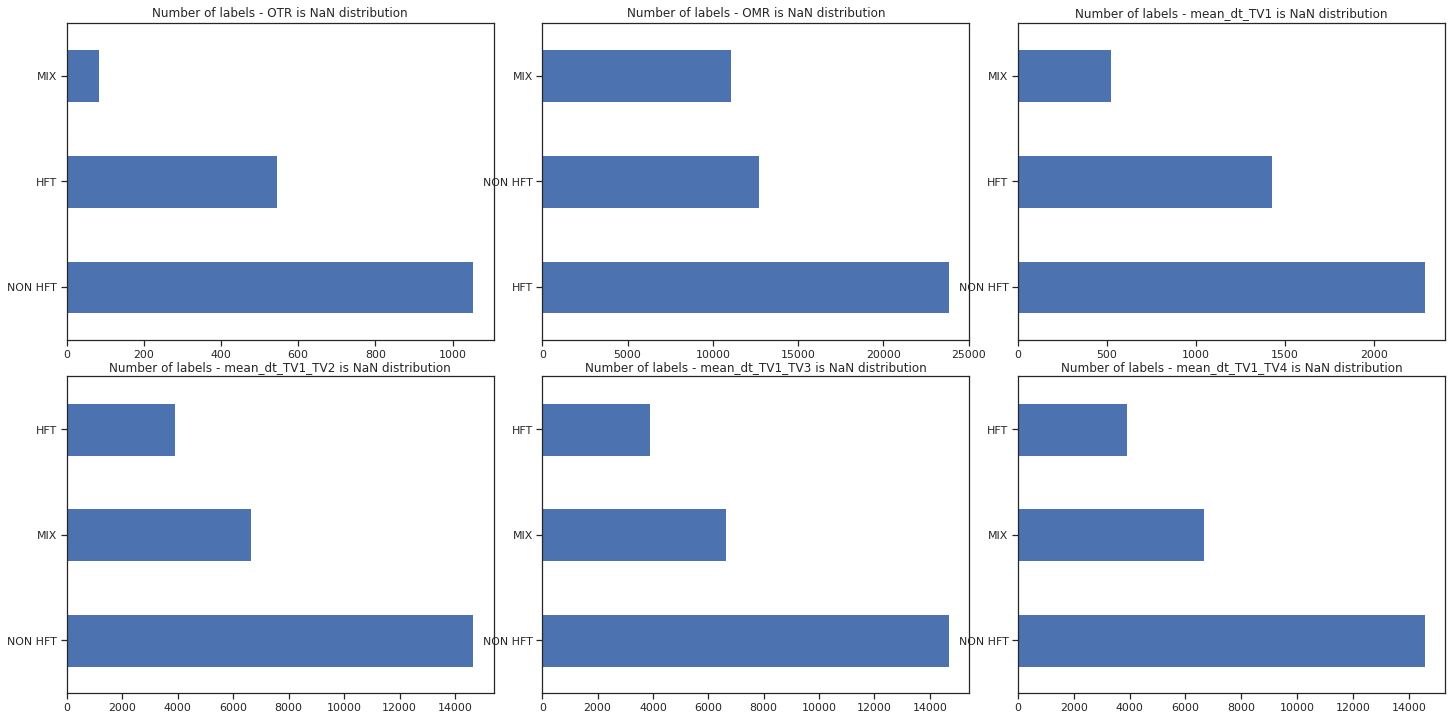

In [ ]:
labels = ["OTR", "OMR", "mean_dt_TV1", "mean_dt_TV1_TV2", "mean_dt_TV1_TV3", "mean_dt_TV1_TV4"]
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
fig.tight_layout()
label_idx = 0

for i in range(2):
  for j in range(3):
    place = axs[i, j]
    if label_idx == len(labels):
      continue
    label = labels[label_idx]
    train_x_only_nan = train_xy[train_xy[label].isna()]
    train_x_only_nan['type'].value_counts().plot(kind="barh", ax=place)
    place.set_title("Number of labels - {} is NaN distribution".format(label))
    label_idx += 1

plt.show()

In conclusion, the rows that have NaN values follow a different distribution compared to all values together. While the distribution of all values have a majority of MIX Traders, when we consider only NaN values rows it changes a lot. 

In order to not lose this important information that NaN values give to us, we will not replace it by the average column value or drop it, we will replace it by -1, and it will mean that there are no values there, but at the same time we will be able to use this NaN value information in our models.

In [ ]:
# replace NaN values for -1 for the visualization
train_xy = train_xy.fillna(-1)

### Visualization

In this next step, we will visualize our data to identify any obvious relation, to check if our dataset is balanced and to see which variables are more relavant to our problem. We also may check for correlations in order to apply some algorithms to reduce dimensionality.

In [ ]:
X_visualize = train_xy.drop(columns=['Trader', 'Day', 'Share'])

### Correlation

As we have a lot of variables, and many of them seem to have a strong correlation (like variables describing tradings), we will plot below a heatmap with the correlation values.

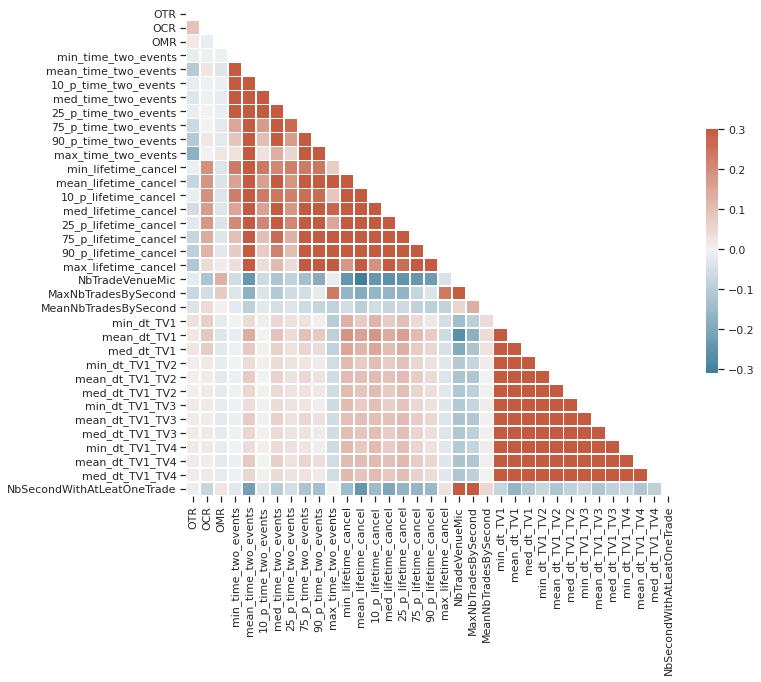

In [ ]:
corr = X_visualize.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
f.show()

As expected, variables like min_dt_TV1, mean_dt_TV1, ..., are strongly correlated, and also the statistics about time between two events and lifetime cancel of orders. So a PCA is a good idea to reduce the dimension while maintaining the quality. 

### Plots

Below, we plot the distribution of each variable normalized. 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


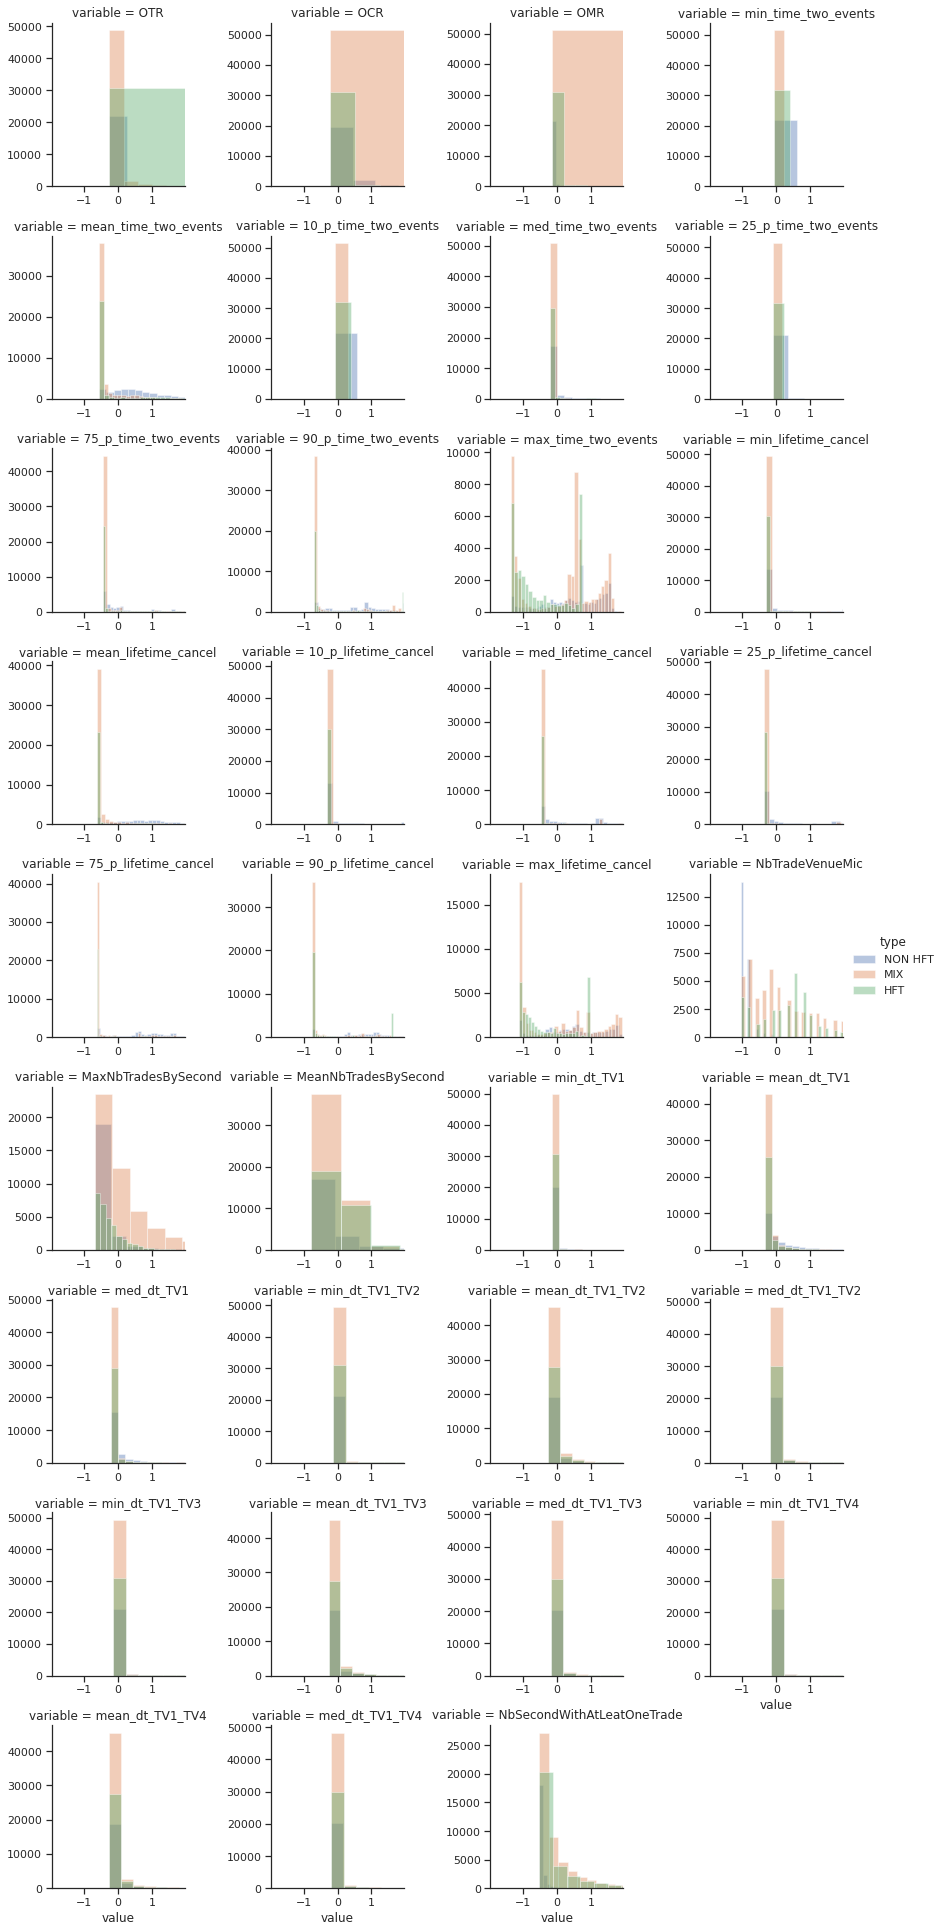

In [ ]:
X_norm, y = X_visualize.drop(columns=['type']), X_visualize['type']
X_norm = (X_norm - X_norm.mean()) / X_norm.std()
X_norm = X_norm.merge(y, left_index=True, right_index=True)
columns = list(X_norm.columns.values)
columns = columns.remove("type")

f = pd.melt(X_norm, id_vars='type', value_vars=columns)
g = sns.FacetGrid(f, hue='type', col="variable", col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.distplot, "value", kde=False).add_legend()
g.set(xlim=(-1.96, 1.96))

### TODO: CONCLUDE PLOT ANALYSIS

In relation to the traders, we can consider some variables as well. Like the number of days that the trader was active and the number of Shares that he trades.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


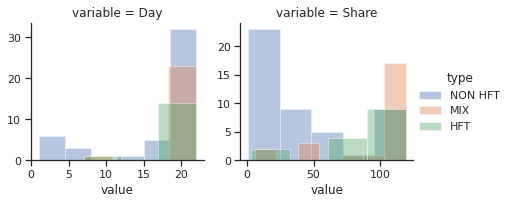

In [ ]:
traders = train_x_df[['Trader', 'Day', 'Share']].copy()
traders = traders.groupby(by="Trader", axis=0).agg({'Day': 'nunique', 'Share': 'nunique'})
featured_data = pd.merge(traders, train_y_df, left_on="Trader", right_on="Trader")

columns = ['Day', 'Share']
f = pd.melt(featured_data, id_vars='type', value_vars=columns)
g = sns.FacetGrid(f, hue='type', col="variable", col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.distplot, "value", kde=False).add_legend()

These variables seem to be a good way to explain our problem, so we decide to add them in our PCA analysis below

## Unsupervised Learning methods

### PCA

We apply unsupervised learning techniques to detect the parameters that are relevant to predict the right category. 

We apply a PCA to our dataset as it is consisted of only numerical variables. Notice that the pre-treated data is used.

A good idea is to join the new features created in the PCA or after PCA. We explore both options.

In [12]:
# Add new variables - Number of distinct Shares and Number of distinct dates
new_data = train_xy.groupby(by="Trader", axis=0).agg({'Day':'nunique', 'Share':'nunique'})
train_xy_all_data = pd.merge(train_xy, 
                    new_data,  
                    on='Trader')
X_visualize = train_xy_all_data.drop(columns=['Trader', 'Day_x', 'Share_x'])

In [5]:
def apply_PCA(df, columns, n_components, normalized=False):
  df = df[columns]
  if 'type' in df:
    df.drop(columns=['type'], inplace=True)
  pca_data = df.to_numpy()
  if not normalized:
    sc = StandardScaler()
    pca_data = sc.fit_transform(df)
  pca = PCA(n_components=n_components)
  principalComponents = pca.fit_transform(pca_data)
  return pca, principalComponents

def visualize_PCA(df, columns, pca, principalComponents):
  fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
  fig.tight_layout(pad=3)

  label = df['type']
  df = df[columns]
  if 'type' in df:
    df.drop(columns=['type'], inplace=True)
  pca_values=pca.components_

  PC_values = np.arange(pca.n_components_) + 1
  axs[0, 0].plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
  axs[0, 0].set_title('Scree Plot')
  axs[0, 0].set_xlabel('Principal Component')
  axs[0, 0].set_ylabel('Proportion of Variance Explained')

  #Plot circle - dim 2 and 3
  #Create a list of 500 points with equal spacing between -1 and 1
  x=np.linspace(start=-1,stop=1,num=500)
  
  #Find y1 and y2 for these points
  y_positive=lambda x: np.sqrt(1-x**2) 
  y_negative=lambda x: -np.sqrt(1-x**2)
  axs[0, 1].plot(x,list(map(y_positive, x)), color='black')
  axs[0, 1].plot(x,list(map(y_negative, x)),color='black')

  #Create broken lines
  x=np.linspace(start=-1,stop=1,num=30)
  axs[0, 1].scatter(x,[0]*len(x), marker='_',color='black')
  axs[0, 1].scatter([0]*len(x), x, marker='|',color='black')

  add_string=""
  for i in range(len(pca_values[0])):
      xi=pca_values[0][i]
      yi=pca_values[1][i]
      axs[0, 1].arrow(0,0, 
                dx=xi, dy=yi, 
                head_width=0.03, head_length=0.03,
                color='black',
                length_includes_head=True)
      axs[0, 1].text(pca_values[0, i], 
              pca_values[1, i] , 
              s=columns[i] + add_string )
      
  axs[0, 1].set_xlabel(f"Component 1 ({round(pca.explained_variance_ratio_[0]*100,2)}%)")
  axs[0, 1].set_ylabel(f"Component 2 ({round(pca.explained_variance_ratio_[1]*100,2)}%)")
  axs[0, 1].set_title('Variable factor map (PCA) of dimensions 1 and 2')

  df_pca = pd.DataFrame()
  df_pca['First dimension'] = principalComponents[:,0]
  df_pca['Second dimension'] = principalComponents[:,1] 
  df_pca['Third dimension'] = principalComponents[:,2]
  df_pca['type'] = label

  sns.scatterplot(
      x="First dimension", y="Second dimension",
      hue="type",
      palette=sns.color_palette("hls", 3),
      data=df_pca,
      legend="full",
      alpha=0.3,
      ax=axs[1, 0]
  )
  axs[1, 0].set_title("PCA - Dimension 1 and 2")

  sns.scatterplot(
      x="Second dimension", y="Third dimension",
      hue="type",
      palette=sns.color_palette("hls", 3),
      data=df_pca,
      legend="full",
      alpha=0.3,
      ax=axs[1, 1]
  )
  axs[1, 1].set_title("PCA - Dimension 2 and 3")

In [14]:
pca, principalComponents = apply_PCA(X_visualize, X_visualize.columns, 30)
visualize_PCA(X_visualize, X_visualize.columns, pca, principalComponents)
plt.show()

ValueError: ignored

In [ ]:
nb_dim=7
variance = pca.explained_variance_ratio_[0:nb_dim].sum()
print("PCA has {:.3f} of its variance represented by {} dimensions".format(variance, nb_dim))

PCA has 0.738 of its variance represented by 7 dimensions


From the plots of explained inertia, we can conclude that:

* We should use either 3 or 7 dimensions of our PCA (where the scree plot changes considerably). We decided to use 7 dimensions of the PCA for the next steps, as it represents 77.2 % of the data variance.

* Our variable factor was not able to show the correlations between the variables and we did not use the labels, so it's inconclusive.

Other than that, we also tried to use MFA to have insights about the data. However, it was inconclusive, as the main idea was to plot the categorical labels with the rest of the data, in order to identify relations of the categories with the other variables. This method showed no relevant results, and thus we omit from this notebook.

### t-SNE

 Here, we use t-sne to visualize the results of the PCA.

In [ ]:
from sklearn.manifold import TSNE

# PCA
_, principalComponents = apply_PCA(X_visualize, X_visualize.columns, 3)

# T-SNE
# tsne = TSNE(n_components=3)
# tsne_components = tsne.fit_transform(principalComponents)

KeyboardInterrupt: ignored

In [ ]:
df = pd.DataFrame()

df['tsne-one'] = tsne_components[:,0]
df['tsne-two'] = tsne_components[:,1] 
df['tsne-three'] = tsne_components[:,2]
df['type'] = train_x['type']

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-one", y="tsne-two",
    hue="type",
    palette=sns.color_palette("hls", 3),
    data=df,
    legend="full",
    alpha=0.3
)
plt.plot()

Notice that we decided to only use t-SNE for visualizations purposes on the PCA, since its output varies every time the algorithm is run.

### Conclusion

From all these methods, we realize that we should try to feed our supervised learning approaches with three alternatives:

* Apply PCA to our data without information about Data and Shares
* Apply PCA to our data and the information extracted from Data and Shares
* Append the first PCA to the extracted features

## Supervised Learning

### Loss function

In the challenge, it is used a micro-averaged F1-score. This one calculates de F1-score shown below by counting globally the total number of true positives, false negatives and false positives.

$$ F1 = 2 \cdot \frac{\text{precision}\cdot\text{recall}}{\text{precision} + \text{recall}} $$

Notice that this loss function is good for not perfectly balanced datasets, which is our case. Thus, we decided to not undersample or oversample our dataset.

### Methods

Now, after treating our data and identifying the most important parameters, we proceed to apply a supervising learning technique.

Before proceeding to the techniques, we need to first discuss how will we get the classification of each trader from all the points he/she appears.

A first idea is to use the same proportions proposed in the baseline method. However, we can try to go further by finding the right proportion. In order to do that, we first save the predicted value for each line and then we use $n$ different proportions and we see which one fits better the data. This is done for each method and, in the end, we compare all our results. 

### Support functions

We create some support functions used for our supervised learning methods. They are presented below.

In [6]:
# normalization
normalizer = StandardScaler()

# Encoder to use
encoder = preprocessing.LabelEncoder()
encoder.fit(["HFT", "NON HFT", "MIX"])

LabelEncoder()

In [7]:
def transform_day(day_col, traders, normalize=False):
  '''
  Transform the data to the feature detailed
  '''
  both_data = pd.merge(traders, day_col, on="Index")
  both_data = both_data.groupby(by="Trader", axis=0).agg({'Day':'nunique'})
  return both_data[['Day']]


def transform_share(share_col, traders):
  '''
  Transform the share to the feature detailed
  '''
  both_data = pd.merge(traders, share_col, on="Index")
  both_data = both_data.groupby(by="Trader", axis=0).agg({'Share':'nunique'})
  return both_data[['Share']]


def pre_processing(X, apply_pca=True, nb_dimensions=7):
  '''
  Function that returns preprocessed data
  '''
  X_treated = X.fillna(-1)
  idx = X_treated.index.copy()
  pca_used = None

  traders = pd.DataFrame(X_treated[['Trader']].copy(), 
                         index=idx, columns = ["Trader"])
  
  X_treated = X_treated.drop(columns=["Day", "Share"])
  # add new variables
  X_treated = pd.merge(X_treated, 
                        transform_day(X[['Day']], traders), on='Trader')
  X_treated = pd.merge(X_treated, 
                        transform_share(X[['Share']], traders), on='Trader')
  X_treated.index = idx

  X_treated = X_treated.drop(columns='Trader')
  normalized_data = normalizer.fit_transform(X_treated)
  X_treated = pd.DataFrame(normalized_data, columns=X_treated.columns,
                           index=idx)

  # We do the PCA if it's the case:
  if apply_pca:
    pca_used, pca_return = apply_PCA(X_treated, X_treated.columns, nb_dimensions)
    X_treated = pd.DataFrame(pca_return, index=idx)

  # We put the traders together
  X_treated = pd.merge(traders, X_treated, on="Index")
  return X_treated, pca_used


def pre_processing_eval(X_eval, previous_pca, nb_dimensions=7):
  '''
  Function that returns preprocessed data
  '''
  X_treated = X_eval.fillna(-1)
  idx = X_treated.index.copy()

  traders = pd.DataFrame(X_treated[['Trader']].copy(), 
                         index=idx, columns = ["Trader"])

  X_treated = X_treated.drop(columns=["Day", "Share"])

  X_treated = pd.merge(X_treated, 
                        transform_day(X_eval[['Day']], traders), on='Trader')
  X_treated = pd.merge(X_treated, 
                        transform_share(X_eval[['Share']], traders), on='Trader')
  X_treated.index = idx

  X_treated = X_treated.drop(columns='Trader')
  normalized_data = normalizer.transform(X_treated)
  X_treated = pd.DataFrame(normalized_data, columns=X_treated.columns,
                           index=idx)

  # We do the PCA if it's the case:
  if previous_pca is not None:
    pca_output = previous_pca.transform(X_treated)
    X_treated = pd.DataFrame(pca_output, index=idx)

  # We put the traders together
  X_treated = pd.merge(traders, X_treated, on="Index")

  return X_treated


def split_data(X, y, shuffle=True, random_state=42, test_size=0.2):
  '''
  Transform the data to two sets: one of validation and other one
  of training
  '''
  transition_y = pd.merge(X, y, on="Trader")[["type"]]

  X_train, X_test, y_train, y_test = train_test_split(X, transition_y, 
                                                      shuffle=shuffle, 
                                                      test_size=test_size, 
                                                      random_state=random_state)

  trader_info_train = pd.DataFrame(X_train[['Trader']].copy(), 
                         index=X_train.index.copy(), columns = ["Trader"])
  trader_info_test = pd.DataFrame(X_test[['Trader']].copy(), 
                         index=X_test.index.copy(), columns = ["Trader"])
  
  X_train = X_train.drop(columns=['Trader'])
  X_test = X_test.drop(columns=['Trader'])
  y_train = encode_y(y_train)
  y_test = encode_y(y_test)
  return X_train, X_test, y_train, y_test, trader_info_train, trader_info_test


def clean_eval_data(X):
  '''
  Function to transform eliminate Trader column and save it somewhere else
  '''
  trader_info_eval = pd.DataFrame(X[['Trader']].copy(),columns = ["Trader"])
  X_eval = X.drop(columns=['Trader'])

  return X_eval, trader_info_eval


def join_x_y(X, y, random_state=42):
  '''
  Prepare X and y to train models, use this function if you do not want to split in
  train and test dataset
  '''
  transition = pd.merge(X, y, on="Trader")
  transition.index = X.index
  trader_info = pd.DataFrame(transition[['Trader']].copy(), 
                index=transition.index.copy(), columns = ["Trader"])
  X, y = transition.drop(columns=['type', 'Trader']), transition['type']
  y = encode_y(y)
  return X, y, trader_info

def encode_y(y):
  y = encoder.transform(y)
  return y

def naive_approach(y, trader_info):
  '''
  Function that transforms the predicted transitions to
  traders predictions
  '''
  pass

Given the ideas proposed, we calculate the variance represented by using the new variables defined, just to be sure if the choice of 7 dimensions is still a good idea considering that:

## Evaluation

Below there are some general functions in order to achieve the best model performance.

We want our model to predict well the tradings between the 3 labels, and after gathering the best results, we want another model to classify our Traders in the possible labels as well.

In [8]:
from sklearn.model_selection import GridSearchCV

def grid_search(X, Y, estim, param_grid, folds=3):
  gs = GridSearchCV(estim, param_grid, scoring=["f1_micro"], refit='f1_micro', verbose=1, n_jobs=-1, cv=folds)
  gs.fit(X, Y)
  return gs

## Models - Tradings classification

The first task is to classify our tradings in the 3 labels. Below we create our X and Y dataset pre-processed. We will use:

* **X_full**: all pre-processed data;
* **X_pca**: PCA with 7 dimensions;

In [9]:
X_full, _ = pre_processing(train_x_df, apply_pca=False, nb_dimensions=7)
X_full, y_full, trader_info_train_full = join_x_y(X_full, train_y_df)

In [10]:
X_pca, pca = pre_processing(train_x_df, apply_pca=True, nb_dimensions=7)
X_pca, y_pca, trader_info_train_pca = join_x_y(X_pca, train_y_df)

In [11]:
X_eval_full = pre_processing_eval(eval_df, previous_pca=None, nb_dimensions=7)
X_eval_full, trader_info_eval_full = clean_eval_data(X_eval_full)

In [12]:
X_eval_pca = pre_processing_eval(eval_df, previous_pca=pca, nb_dimensions=7)
X_eval_pca, trader_info_eval_pca = clean_eval_data(X_eval_pca)

### Random Forest

Random Forests are a more complex class of predictors which usually are able to achieve good performance on classification tasks. We train ensembles of random forests using scikit-learn's implementation and tuning the following parameters:

* **n_estimators**: the number of trees on the forest;
* **criterion**: the function to measure the quality of a split, either gini for the Gini impurity and entropy for the information gain;
* **min_samples_leaf**: the minimum number of samples required to be at a leaf node.


In [22]:
from sklearn.ensemble import RandomForestClassifier

rndForest = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100],
    'criterion': ['gini', 'entropy'],
    'min_samples_leaf': [1, 5, 10, 30]
}

In [23]:
# Full dataset
rndForest_full = grid_search(X_full, y_full, rndForest, param_grid)
print('FULL Best Score: {:}'.format(rndForest_full.best_score_))
print('FULL Best Hyperparams:', rndForest_full.best_params_)

In [53]:
rndForest = RandomForestClassifier(random_state=42, criterion="entropy", n_estimators=200, min_samples_leaf=1)
new_x,_ = pre_processing(train_x_df, apply_pca=False, nb_dimensions=7)

X_train, X_test, y_train, y_test, _, _ = split_data(new_x, train_y_df)

rndForest.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [54]:
print(rndForest.score(X_test, y_test))

0.9881363142222432


In [27]:
rndForest2 = RandomForestClassifier(random_state=42, criterion="entropy", n_estimators=100, min_samples_leaf=1)
rndForest2.fit(X_full, y_full)
print(rndForest2.score(X_full, y_full))

0.9999905465958292


In [ ]:
# PCA dataset
rndForest_pca = grid_search(X_pca, y_pca, rndForest, param_grid)
print('FULL Best Score: {:}'.format(rndForest_pca.best_score_))
print('FULL Best Hyperparams:', rndForest_pca.best_params_)

### Gradient Boosting

Now, we use decision trees trained via gradient boosting. We opted to use XGBoost's implementation. Tuning XGBoost's hyperparameters is a task that can demand ample computational resources, which is why we opt to tune only a small subset of hyperparameters with few different values. These parameters are:

* **learning_rate**: the boosting learning rate;
* **n_estimators**: number of gradient boosted trees.
* **min_child_weight**: minimum sum of instance weight needed in a child.


In [ ]:
from xgboost import XGBClassifier

boostedtree = XGBClassifier(max_depth=3, booster='gbtree', random_state=42)

param_grid = {
    'learning_rate': [1e-2, 5e-2, 1e-1],
    'n_estimators': [50, 100, 150],
    'min_child_weight': [1, 3, 5],
}

In [ ]:
# Full dataset
boostedtree_full = grid_search(X_full, y_full, boostedtree, param_grid)
print('FULL Best Score: {:}'.format(boostedtree_full.best_score_))
print('FULL Best Hyperparams:', boostedtree_full.best_params_)

In [ ]:
# PCA dataset
boostedtree_pca = grid_search(X_pca, y_pca, boostedtree, param_grid)
print('FULL Best Score: {:}'.format(boostedtree_pca.best_score_))
print('FULL Best Hyperparams:', boostedtree_pca.best_params_)

### KNN

A KNN approach to our problems seems reasonable because our the PCA of our dataset is quite clustered. We will optimize our model by choosing the right number of neighbors.

* **n_neighbors**: Number of neighbors.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

KNN = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [1, 3, 5, 7],
}

In [ ]:
# PCA dataset
KNN_pca = grid_search(X_pca, y_pca, KNN, param_grid)
print('FULL Best Score: {:}'.format(KNN_pca.best_score_))
print('FULL Best Hyperparams:', KNN_pca.best_params_)

### Logistic regression

It is always worth to try simple methods such as Logistic Regression and check their results. We also use them to compare with our previous and further results.

We tried to tune the following hyperparameters:

* **class_weight**: depending on the method used, different weights are given for the data in order to attack the unbalance of the data.
* **solver**: algorithm used in the optimization problem.

In [13]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(multi_class='multinomial', random_state=42, max_iter=200)

param_grid = {
    'class_weight' : [None, 'balanced'],
    'solver': ['newton-cg', 'sag', 'saga', 'lbfgs'],
}

In [63]:
# Full dataset
logreg_full = grid_search(X_full, y_full, logreg, param_grid)
print('FULL Best Score: {:}'.format(logreg_full.best_score_))
print('FULL Best Hyperparams:', logreg_full.best_params_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  3.7min finished


FULL Best Score: 0.7223251115178808
FULL Best Hyperparams: {'class_weight': None, 'solver': 'saga'}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [14]:
# PCA dataset
logreg_pca = grid_search(X_pca, y_pca, logreg, param_grid)
print('FULL Best Score: {:}'.format(logreg_pca.best_score_))
print('FULL Best Hyperparams:', logreg_pca.best_params_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
FULL Best Score: 0.5985803274030914
FULL Best Hyperparams: {'class_weight': 'balanced', 'solver': 'sag'}


The main problem here is that we tried to use a maximum number of iterations of 100, 200 and 300. Regardless of the number of maximum iterations, the logistic regressor didn't converge for one of the methods as it says in the warning message, and had almost the same best score. Thus we decided to keep 100, so it's faster for someone who wants to execute the notebook.

### Support Vector Machine

We decided to use a SVC (Support Vector Classifier) as well. However this method is only defined for binary classification problems. Thus, we needed to use the function OneVsRestClassifier. This method uses the Binary Relevance method to perform the multilabel classification, which involves training one binary classificator for each of the labels. In our case, this classificator is the SVC. 

We did a grid search as well for this method and we analyzed the following hyperparameters:

* **decision_function_shape**: whether to return a one-vs-rest ('ovr') or a one-vs-one ('ovo') decision function.
* **kernel**: kernel type to be used in the algorithm.
* **gamma**: kernel coefficient for 'rbf', 'poly' and 'sigmoid'.


In [17]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

svm = OneVsRestClassifier(SVC())

param_grid = {
    'estimator__decision_function_shape' : ['ovr', 'ovo'],
    'estimator__kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
    'estimator__gamma' : ['scale', 'auto'], 
}

In [ ]:
# Full dataset
svc_full = grid_search(X_full, y_full, svm, param_grid)
print('FULL Best Score: {:}'.format(svc_full.best_score_))
print('FULL Best Hyperparams:', svc_full.best_params_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [ ]:
# PCA dataset
svc_pca = grid_search(X_pca, y_pca, svc, param_grid)
print('FULL Best Score: {:}'.format(svc_pca.best_score_))
print('FULL Best Hyperparams:', svc_pca.best_params_)

## Transforming our predictions into traders' predictions

### Naive approach

We simply used specific values considering the proportions of predictions in order to calculate the final prediction for the trader. This implementation is above already with the rest of the support functions.

We decided as well to try different possible proportions to decide which is the classification of the trader.

### Calculating the mode

Other approach the we could think of was to choose the mode of our results as the final result. We implement it here:

### Other approaches

We also tried to use a decision tree to choose which was the final classification of the trader. However, it didn't work, so we omit it from here.